Already existing analyses: 
- https://www.ijrte.org/wp-content/uploads/papers/v8i2S3/B11630782S319.pdf
- https://towardsdatascience.com/heart-disease-uci-diagnosis-prediction-b1943ee835a7

In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

In [2]:
import numpy as np
import pandas as pd 
from category_encoders import TargetEncoder
import os
dataset = pd.read_csv('heart.csv')

In [3]:
dataset.head(1)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0


Description of the features that can be found on https://ieee-dataport.org/open-access/heart-disease-dataset-comprehensive, plus some quotes from random websites (I have no medical education whatsoever, so I needed to explain myself a lot of terms.)
#### 1. Age (in years) - Numeric
#### 2. Sex (M/F) - Binary
#### 3. Chest pain type (1, 2, 3, 4) - Nominal
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic

_Angina_ is a type of chest pain caused by reduced blood flow to the heart.

_Typical angina_ chest pain consists of (1) Substernal chest pain or discomfort that is (2) Provoked by exertion or emotional stress and (3) relieved by rest or nitroglycerine (or both). 

_Atypical angina_ chest pain applies when 2 out of 3 criteria of classic angina are present.

_Non-anginal chest pain_, which doctors may also call noncardiac chest pain, refers to pain a person without heart disease may feel behind the breast bone. The pain may feel similar to angina, but it occurs due to **different causes**. This type of pain often results from issues with the esophagus, lungs, or other causes. Nonanginal chest pain may feel like pressure or squeezing pain behind the breast bone that may extend to the neck, back, or left arm. A person may also experience other symptoms such as heartburn or regurgitation alongside the chest pain. People may notice it after eating or drinking, and it may last a few seconds to many hours.

_A silent (asymptomatic)_ heart attack, known as a silent myocardial infarction (SMI), account for **45% of heart attacks and strike men more than women**.

#### 4. Resting Blood Pressure (systolic) - Numeric

One-minute video for complete dummies: https://www.youtube.com/watch?v=rc4vipEx__U

**Norms of systolic blood pressure** by age and gender:
<br>(18-39 years) Men: 110 mmHg; Women: 119 mmHg<br>(40-59 years) Men: 122 mmHg; Women: 124 mmHg<br>(60+ years) Men: 139 mmHg; Women: 133 mmHg

#### 5. Serum Cholesterol (mg/dl) - Numeric

Once again, a video for dummies :)
https://www.youtube.com/watch?v=0U7YHRW5dyc
<br> "Good" and "bad" cholesterol are produced in our liver.

Norms:

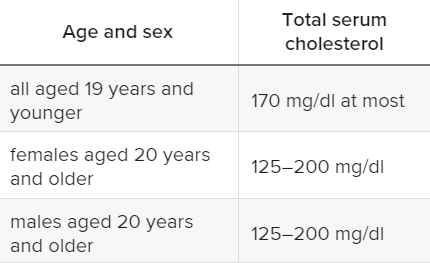

#### 6. Fasting Blood Sugar (1, 0) - Binary
    - Value > 120 mg/dl
    
https://www.youtube.com/watch?v=Swg05Gv0wMU&list=WL&index=97

Over time, _high blood sugar_ can damage blood vessels and the nerves that control your heart. People with diabetes are also more likely to have other conditions that raise the risk for heart disease: High blood pressure increases the force of blood through your arteries and can damage artery walls.

Note: High blood sugar causes corrosion of the vessels. Some of the sugar turns into cholesterol, which returns us to point 5.

The expected values for normal fasting blood glucose concentration are between **70 mg/dL** and **100 mg/dL**.


#### 7. Resting ECG (0, 1, 2) - Nominal
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

Normal ECG and abnormalities
<br>
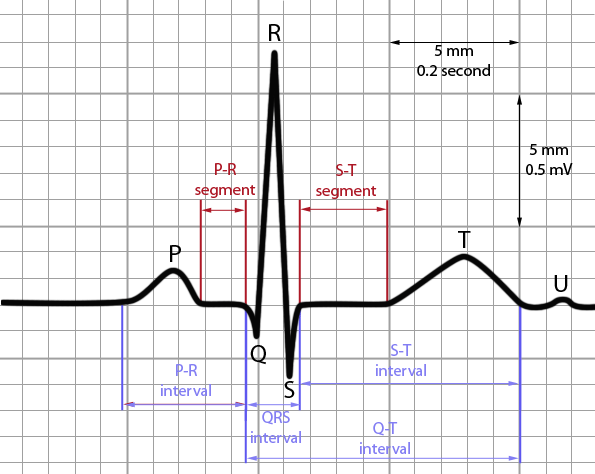
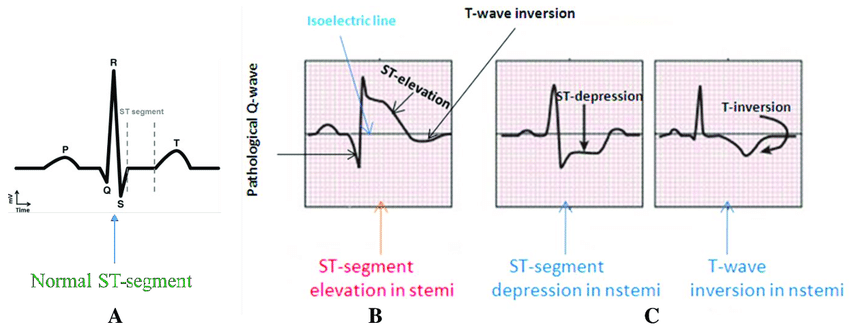

Causes of ST elevation: coronary artery spasm

#### 8. Maximum Heart Rate Achieved (71 - 202) - Numeric

Some article: https://www.heart.org/en/healthy-living/fitness/fitness-basics/target-heart-rates

If heart rate gets too high, it can affect blood flow through the heart. And this can lead to symptoms — like chest pain — or even injury to the heart muscle. 

Note: maximum heart rate for a person is evaluated as **220 - age**.

#### 9. Exercise Induced Angina (1, 0) - Binary 

Whether or not exercises give a person anginal chest pain.

#### 10. oldpeak=ST (depression) - Numeric
In millimeters, I guess.
<br>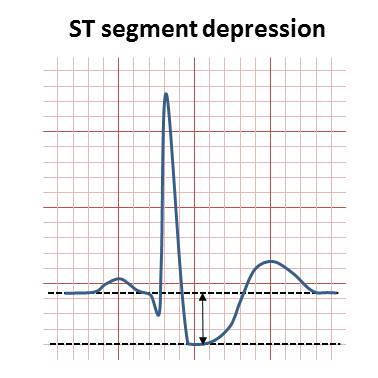
<br>-- Illustration of _upsloping ST segment depression_ (Wiki) --
#### 11. The slope of the peak exercise ST segment (0, 1, 2) - Nominal
    - Value 1: upsloping
    - Value 2: flat
    - Value 3: downsloping

<br> 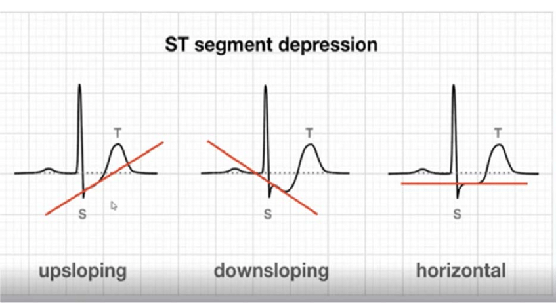
#### 12. Heart Disease - Target, Binary

#### Assumptions: 
Heart disease will probably be encountered in older men .......

And now that we've seen all of the fancy ECG pictures, lets do some coding :)

Train/Test split:

In [4]:
categorical = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numerical = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
target = 'HeartDisease'

In [5]:
print(dataset.HeartDisease.value_counts())
print('\ndataset is balanced, we can just split.')

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(dataset, dataset[target]):
    train = dataset.loc[train_idx]
    test = dataset.loc[test_idx]

1    508
0    410
Name: HeartDisease, dtype: int64

dataset is balanced, we can just split.


In [6]:
fixed_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Baseline:

In [7]:
basic_transformer = ColumnTransformer([('cat', OneHotEncoder(), categorical), 
                                 ('num', StandardScaler(), numerical)], 
                                remainder='drop', verbose_feature_names_out=False)

train_X = pd.DataFrame(basic_transformer.fit_transform(train), columns = basic_transformer.get_feature_names_out())
train_y = train[target]

In [8]:
import lightgbm as lgb
lgb_params = {
    "objective": "binary",
    "learning_rate": 0.09,
    "num_threads": 10,
    "metric": "binary_error",
    "seed": 42,
   "verbose":-1,

    
     #regularization
    "max_depth":3,
    "colsample_bytree": 0.7,
    "subsample": 0.9,
    "subsample_freq": 1,
    "min_data_in_leaf": 60,
    "num_leaves":6,
    
    "n_estimators":10_000
    
    #categorical features
#     'cat_smooth': 5,
#     'min_data_per_group': 2

}
lgb_train = lgb.Dataset(train_X, label=train_y, free_raw_data=False)
result = lgb.cv(lgb_params, lgb_train, 10_000, folds=fixed_skf, callbacks=[lgb.early_stopping(10), lgb.log_evaluation(10)], eval_train_metric=True, return_cvbooster=True)
lgb_params['n_estimators'] = result["cvbooster"].best_iteration
result.pop('cvbooster')

Training until validation scores don't improve for 10 rounds
[10]	cv_agg's train binary_error: 0.146118 + 0.0107487	cv_agg's valid binary_error: 0.160759 + 0.0311786
[20]	cv_agg's train binary_error: 0.13556 + 0.00790425	cv_agg's valid binary_error: 0.151207 + 0.0352447
[30]	cv_agg's train binary_error: 0.117506 + 0.0116983	cv_agg's valid binary_error: 0.138962 + 0.032922
[40]	cv_agg's train binary_error: 0.113418 + 0.0116144	cv_agg's valid binary_error: 0.13215 + 0.036139
[50]	cv_agg's train binary_error: 0.101837 + 0.00689455	cv_agg's valid binary_error: 0.123968 + 0.0368267
[60]	cv_agg's train binary_error: 0.097068 + 0.00659592	cv_agg's valid binary_error: 0.132159 + 0.0376774
Early stopping, best iteration is:
[52]	cv_agg's train binary_error: 0.100814 + 0.00886932	cv_agg's valid binary_error: 0.121256 + 0.0328877


C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [9]:
initial_lgb_result_without_target_encoding = 1-pd.DataFrame(result).iloc[-1][::2]
initial_lgb_result_without_target_encoding

train binary_error-mean    0.899186
valid binary_error-mean    0.878744
Name: 51, dtype: float64

In [108]:
target_encoder = TargetEncoder(cols=categorical)
train_cat_encoded, train_y = target_encoder.fit_transform(train[categorical], train[target]), train[target].reset_index(drop=True)
train_X = pd.DataFrame(basic_transformer.fit_transform(train), columns = basic_transformer.get_feature_names_out())
train_X = pd.concat([train_X, train_cat_encoded.reset_index(drop=True)], axis=1)

In [109]:
import lightgbm as lgb
lgb_params = {
    "objective": "binary",
    "learning_rate": 0.05,
    "num_threads": 10,
    "metric": "binary_error",
    "seed": 42,
   "verbose":-1,

    
     #regularization
    "max_depth":4,
    "colsample_bytree": 0.6,
    "subsample": 0.9,
    "subsample_freq": 1,
    "min_data_in_leaf": 60,
    "num_leaves":7,
    
    "n_estimators":10_000
    
    #categorical features
#     'cat_smooth': 5,
#     'min_data_per_group': 2

}
lgb_train = lgb.Dataset(train_X, label=train_y, free_raw_data=False)
result = lgb.cv(lgb_params, lgb_train, 10_000, folds=fixed_skf, callbacks=[lgb.early_stopping(10), lgb.log_evaluation(10)], eval_train_metric=True, return_cvbooster=True)
lgb_params['n_estimators'] = result["cvbooster"].best_iteration
result.pop('cvbooster')

Training until validation scores don't improve for 10 rounds
[10]	cv_agg's train binary_error: 0.166205 + 0.018918	cv_agg's valid binary_error: 0.183972 + 0.0362822
[20]	cv_agg's train binary_error: 0.162468 + 0.0128907	cv_agg's valid binary_error: 0.170254 + 0.0402046
[30]	cv_agg's train binary_error: 0.143733 + 0.0140283	cv_agg's valid binary_error: 0.155279 + 0.036485
[40]	cv_agg's train binary_error: 0.126703 + 0.00905667	cv_agg's valid binary_error: 0.145755 + 0.0383119
[50]	cv_agg's train binary_error: 0.118868 + 0.00976473	cv_agg's valid binary_error: 0.126698 + 0.0400222
[60]	cv_agg's train binary_error: 0.113077 + 0.00849586	cv_agg's valid binary_error: 0.129429 + 0.0405905
Early stopping, best iteration is:
[52]	cv_agg's train binary_error: 0.117164 + 0.00920652	cv_agg's valid binary_error: 0.121247 + 0.0392706


C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [110]:
initial_lgb_result_with_target_encoding = 1-pd.DataFrame(result).iloc[-1][::2]
initial_lgb_result_with_target_encoding

train binary_error-mean    0.882836
valid binary_error-mean    0.878753
Name: 51, dtype: float64

https://github.com/terpiljenya/machine_learning_projector/blob/main/lectures/11.0%20-%20Feature%20Engineering.ipynb

#### Feature Engineering

In [13]:
import xgbfir
import xgboost as xgb

In [111]:
xgb_params = {
    'objective': 'binary:logistic',
    "learning_rate": 0.1,
    "eval_metric": "error",
    "seed": 42,
    
     "max_depth":4,
    "colsample_bytree": 0.4,
    "subsample": 0.8,
    'gamma': 0.0,
    "max_leaves":10,
}
xgb_train = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns)

num_rounds = 10_000
results = xgb.cv(
    xgb_params, 
    xgb_train, 
    num_rounds, 
    early_stopping_rounds=10,
    folds=fixed_skf, 
    verbose_eval=10)
xgb_params['n_estimators'] = list(results['test-error-mean']).index(min(list(results['test-error-mean'])))
1-results.iloc[-1, [0, 2]]

[0]	train-error:0.15463+0.00860	test-error:0.17841+0.05715
[10]	train-error:0.10763+0.00689	test-error:0.14165+0.04769
[20]	train-error:0.09502+0.01060	test-error:0.13755+0.03596
[23]	train-error:0.09298+0.01017	test-error:0.13755+0.03622


train-error-mean    0.898161
test-error-mean     0.865157
Name: 14, dtype: float64

In [112]:
model = xgb.train(xgb_params, xgb_train, num_boost_round=xgb_params['n_estimators'])

[20:24:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



In [101]:
xgbfir.saveXgbFI(
    model, 
    feature_names=train_X.columns, 
    OutputXlsxFile="xgbfir_importance_heart_dataset.xlsx"
)

In [104]:
interactions = pd.read_excel('xgbfir_importance_heart_dataset.xlsx', sheet_name='Interaction Depth 1')

In [105]:
interactions.head(20)

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,ChestPainType|ST_Slope_Up,473.233961,5,2.400270,0.480054,94.646792,232.979283,1,6,1,9,5,1,3.833333,9.000000,1.000000
1,Cholesterol|ST_Slope_Up,398.782702,3,1.424399,0.474800,132.927567,179.603802,2,19,7,11,3,3,7.500000,6.000000,1.000000
2,ST_Slope|Sex_F,324.817302,2,1.149834,0.574917,162.408651,186.062050,3,31,12,5,2,2,9.166667,4.000000,1.000000
3,ChestPainType_ASY|ST_Slope_Up,301.343154,3,1.428598,0.476199,100.447718,147.811742,4,20,6,10,4,4,8.000000,7.666667,1.000000
4,Oldpeak|ST_Slope,256.514837,4,1.157610,0.289403,64.128709,102.745360,5,9,11,32,8,7,12.000000,9.250000,1.750000
5,ChestPainType_ASY|ST_Slope,255.228586,4,2.011241,0.502810,63.807147,121.549068,6,10,2,8,10,6,7.000000,11.250000,1.000000
6,ExerciseAngina_Y|ST_Slope_Up,247.279587,1,0.575601,0.575601,247.279587,142.334470,7,56,32,4,1,5,17.500000,0.000000,1.000000
7,ChestPainType|MaxHR,191.780215,3,1.249674,0.416558,63.926738,83.297452,8,21,8,16,9,8,11.666667,6.666667,1.333333
8,Cholesterol|ExerciseAngina_N,171.659543,6,1.997443,0.332907,28.609924,80.954832,9,2,3,25,19,10,11.333333,8.500000,2.166667
9,ChestPainType|Oldpeak,153.567100,2,0.858339,0.429170,76.783550,81.999132,10,32,18,14,6,9,14.833333,2.000000,2.000000


As we can see, target encoded categorical features are quite important

In [173]:
train_y[(~train_X.ChestPainType_ASY.astype(bool) & ~train_X.ST_Slope_Flat.astype(bool))].value_counts()

0    204
1     16
Name: HeartDisease, dtype: int64

In [41]:
class GridBuilder:
    def __init__(self, params):
        self.params = params
        
    def build_param_grid(self):
        first_key = list(self.params.keys())[0]
        dots = []

        values = self.params.pop(first_key)
        if (self.params):
            for dot in self.build_param_grid():
                for value in values:
                    dot_copy = dot.copy()
                    dot_copy[first_key] = value
                    dots.append(dot_copy)
            return dots
        else:
            for value in values:
                dot = {}
                dot[first_key] = value
                dots.append(dot)
            return dots   

In [66]:
def entropy(y):
    classes, counts = np.unique(y, return_counts=True)
    entropy_ = 0
    for count in counts:
        entropy_ -= count/counts.sum()*np.log2(count/counts.sum())
    return entropy_

In [73]:
def expected_gain(y, split):
    rows = len(y)
    Entropy_parent = entropy(y)
    Entropy_child_0 = entropy(y[~split])
    Entropy_child_1 = entropy(y[split])
    EG = Entropy_parent - (len(y[~split])/rows*Entropy_child_0 + len(y[split])/rows*Entropy_child_1)
    return EG

In [158]:
from sklearn.base import TransformerMixin, BaseEstimator

class InteractionsGenerator(BaseEstimator, TransformerMixin):
    
    def __init__(self, categorical, numerical, xgb_model, first_n, path):
        self.categorical = categorical
        self.numerical = numerical
        self.xgb_model = xgb_model
        self.first_n = first_n
        self.path = path
    
    def fit(self, X, y):
        return self
    
    def transform(self, X, y):
    
        xgbfir.saveXgbFI(
        self.xgb_model, 
        feature_names=X.columns, 
        OutputXlsxFile=self.path)
        
        return self.interactions_depth_1(X, y)
    
    def fit_transform(self, X, y):
        return self.transform(X, y)
    
    def interactions_depth_1(self, X, y):
        interactions_1 = pd.read_excel(self.path, sheet_name='Interaction Depth 1')['Interaction'][:self.first_n].to_list()
        interactions_1 = [interaction.split('|') for interaction in interactions_1]
        generated = []
        for interaction in interactions_1:
            if all(el in self.categorical for el in interaction):
                generated.append(self.categorical_interactions(X[interaction], y))
#             elif all(el in numerical for el in interaction):
#                 generated.append(self.numerical_interactions(X[interaction]))
#             else:
#                 generated.append(self.mixed_interactions(X[interaction]))
        return pd.concat([X]+generated, axis=1)
                
    
    def categorical_interactions(self, df, y):
        all_logical_interactions = {'a': ['', 'not_'], 'b': ['', 'not_'], 'And/Or': ['And', 'Or']}
        grid = GridBuilder(all_logical_interactions).build_param_grid()
        
        best_EG = -1
        best_interaction = None
        for i, dot in enumerate(grid):
            a = pd.Series(df[df.columns[0]]).astype(bool)
            b = pd.Series(df[df.columns[1]]).astype(bool)
            if dot['a'] == 'not_':
                a = ~a
            if dot['b'] == 'not_':
                b = ~b
            
            if dot['And/Or'] == 'And':
                interaction = a & b
            else:
                interaction = a | b
            
            EG = expected_gain(y, interaction)
            if best_EG < EG:
                best_EG = EG
                best_interaction = interaction.rename(f"{dot['a']}{df.columns[0]}_{dot['And/Or']}_{dot['b']}{df.columns[1]}").astype(int)
        return best_interaction
        
    def numerical_interactions(self, df):
        pass
    
    def mixed_interactions(self, df):
        pass
    
        

In [159]:
basic_transformer.get_feature_names_out()[:-5]

array(['Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA',
       'ChestPainType_NAP', 'ChestPainType_TA', 'FastingBS_0',
       'FastingBS_1', 'RestingECG_LVH', 'RestingECG_Normal',
       'RestingECG_ST', 'ExerciseAngina_N', 'ExerciseAngina_Y',
       'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up'], dtype=object)

In [160]:
categorical_onehot = basic_transformer.get_feature_names_out()[:-5]

In [161]:
generator = InteractionsGenerator(categorical_onehot, numerical, model, 7, 'xgbfir_importance_heart_dataset.xlsx')

In [162]:
new_train_X = generator.fit_transform(train_X, train_y)

In [170]:
train_y[new_train_X.iloc[:, -3].astype(bool)].value_counts()

0    204
1     16
Name: HeartDisease, dtype: int64

In [172]:
new_train_X.columns[-3]

'not_ChestPainType_ASY_And_not_ST_Slope_Flat'